In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS        Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-06  21097     Harrison County          KY                      43.2                    8163            48.1            9092.0
1        2021-11-06  18105       Monroe County          IN                      54.7                   81158            57.9           85920.0
2        2021-11-06  46023  Charles Mix County          SD                      47.3                    4399            59.9            5569.0
3        2021-11-06  41045      Malheur County          OR                      42.2                   12893            47.2           14437.0
4        2021-11-06  39127        Perry County          OH                      36.9                   13339            38.7           13993.0
...             ...    ...                 ...         ...                       ...                     ...             ...               ...
1079792  2020-12-13  26129       Ogemaw County          MI                       0.0                       0             0.0               0.0
1079793  2020-12-13  45045   Greenville County          SC                       0.0                       0             0.0               0.0
1079794  2020-12-13   5145        White County          AR                       0.0                       0             0.0               0.0
1079795  2020-12-13  55025         Dane County          WI                       0.0                       0             0.0               0.0
1079796  2020-12-13  18109       Morgan County          IN                       0.0                       0             0.0               0.0

[1022739 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
28316    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
29348    LA  2020-01-01            0.0                NaN         NaN        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
32436    MN  2020-01-01            0.0                0.0        46.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
30088    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
26693    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
17385    GA  2021-11-06           37.0                7.0     23338.0    18407.0           1314.0         2146.0      352.0            1257.0             57.0     2659.0       0.788714   
12056    NC  2021-11-06            9.0               20.0     22401.0    17517.0           1134.0         1698.0      333.0            1118.0             16.0     2116.0       0.781974   
23174    ID  2021-11-06            6.0               10.0      3301.0     2494.0            435.0          263.0      129.0             430.0              5.0      314.0       0.755529   
23311    UT  2021-11-06            1.0                1.0      5798.0     3824.0            552.0          444.0      177.0             529.0             23.0      618.0       0.659538   
14177    PR  2021-11-06            0.0                0.0      9447.0     6194.0             67.0          455.0       13.0              55.0             12.0      660.0       0.655658   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
28316                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
29348                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
32436                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
30088            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
26693            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
17385            0.072218        0.057093  0.135437      0.807070     8549.0     3728.0     4075.0  
12056            0.065530        0.051247  0.162202      0.802457      462.0      109.0      248.0  
23174            0.177769        0.134094  0.430000      0.837580     1039.0       83.0      494.0  
23311            0.146730        0.096470  0.291118      0.718447      491.0      248.0       83.0  
14177            0.011049        0.007228  0.020701      0.689394        0.0       32.0     1133.0  

[32951 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.1
71.5


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     4157971                       0                 0       262150       3045       3040          65     5152.357143        76.357143     123.915177   
1          1      0 2020-12-29  total_40     4157971                       0                 0       265220       3082       5095         101     5085.214286        77.142857     122.300379   
2          2      0 2020-12-30  total_40     4157971                       0                 0       268222       3126       6072          81     5074.285714        75.428571     122.037545   
3          3      0 2020-12-31  total_40     4157971                       0                 0       270820       3212       5600         130     5033.928571        75.642857     121.066948   
4          4      0 2021-01-01  total_40     4157971                       0                 0       273306       3235       5084         109     4917.285714        74.928571     118.261665   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
308      308      0 2021-11-01  total_40     4157971                 1775043           2051086       668969       9195       2920          57     4517.142857        98.357143     108.638152   
309      309      0 2021-11-02  total_40     4157971                 1776761           2053592       670826       9259       4052         121     4404.428571        96.071429     105.927352   
310      310      0 2021-11-03  total_40     4157971                 1778344           2055788       673396       9333       4427         138     4318.928571        92.428571     103.871060   
311      311      0 2021-11-04  total_40     4157971                 1779754           2057874       675483       9383       4657         124     4217.000000        89.357143     101.419659   
312      312      0 2021-11-05  total_40     4157971                 1781534           2060244       677535       9405       4139          72     4078.428571        86.357143      98.086989   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.836404                  0.000000        0.000000  
1          1.855301                  0.000000        0.000000  
2          1.814072                  0.000000        0.000000  
3          1.819225                  0.000000        0.000000  
4          1.802047                  0.000000        0.000000  
..              ...                       ...             ...  
308        2.365508                  0.426901        0.493290  
309        2.310536                  0.427314        0.493893  
310        2.222925                  0.427695        0.494421  
311        2.149056                  0.428034        0.494923  
312        2.076906                  0.428462        0.495493  

[313 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [16, 54, 56], 'state': ['ID', 'WV', 'WY']}, 45: {'FIPS': [1, 5, 13, 22, 28, 38, 47], 'state': ['AL', 'AR', 'GA', 'LA', 'MS', 'ND', 'TN']}, 50: {'FIPS': [4, 18, 20, 21, 26, 29, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'IN', 'KS', 'KY', 'MI', 'MO', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [19, 31, 55], 'state': ['IA', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 10, 12, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'FL', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 25, 34, 36], 'state': ['MD', 'MA', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 44, 50], 'state': ['CT', 'ME', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc             FIPS      tier total_beds beds_used  \
5902    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5903    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5904    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5905    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5906    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..              ...       ...        ...       ...   
3919    6592849 2021-11-01     13159      727977      1807          7     2406.571429     36.502754        28.142857       0.426869  CT  [9, 23, 44, 50]  total_70    14519.0   11058.0   
3920    6592849 2021-11-02     13181      729648      3210         29     2449.142857     37.148475        26.142857       0.396534  CT  [9, 23, 44, 50]  total_70    14560.0   11515.0   
3921    6592849 2021-11-03     13205      731214      3237         46     2513.000000     38.117057        23.571429        0.35753  CT  [9, 23, 44, 50]  total_70    15367.0   12297.0   
3922    6592849 2021-11-04     13215      733185      3537         34     2592.000000     39.315325        24.428571       0.370531  CT  [9, 23, 44, 50]  total_70    15401.0   12258.0   
3923    6592849 2021-11-05     13239      734766      3552         34     2653.428571      40.24707        25.428571       0.385699  CT  [9, 23, 44, 50]  total_70    15452.0   12344.0   

     covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5902             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5903             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5904             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5905             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5906             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                ...       ...              ...             ...              ...               ...  
3919           584.0    1608.0  0.462051830435809     151.0            575.0             9.0        36.502754          0.426869  
3920           603.0    1606.0  0.523824459300919     158.0            591.0            12.0        37.148475          0.396534  
3921           617.0    1593.0  0.543008320490659     155.0            608.0             9.0        38.117057           0.35753  
3922           613.0    1596.0  0.595937384510524     163.0            605.0             8.0        39.315325          0.370531  
3923           600.0    1606.0  0.524727066568726     154.0            586.0            14.0         40.24707          0.385699  

[4466 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1017095      17221       16199        110    22679.428571   
335  2020-12-22  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1030733      17429       20575        256    22784.142857   
336  2020-12-23  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1043315      17624       26220        403    22928.142857   
337  2020-12-24  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1057617      17798       26884        369    23078.714286   
338  2020-12-25  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1065409      17896       22094        272    22298.857143   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
649  2021-11-01  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3303824      54233        8907         53     7874.285714   
650  2021-11-02  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3306825      54268        9033         83     7655.857143   
651  2021-11-03  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       277.000000    124.371102       1.519033              100          1.519033                      0.0                      0            0.0              0.0  total_30  
335       277.428571    124.945341       1.521383              100          1.521383                      0.0                      0            0.0              0.0  total_30  
336       282.142857    125.735019       1.547236              100          1.547236                      0.0                      0            0.0              0.0  total_30  
337       280.857143    126.560734       1.540185              100          1.540185                      0.0                      0            0.0              0.0  total_30  
338       274.714286    122.284096       1.506498              100          1.506498                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
649        68.714286     27.743805       0.242104        27.743805          0.242104                73.252063               20790503       81.91982       23250598.0  total_70  
650        64.571429     26.974207       0.227507        26.974207          0.227507                73.301967               20804667      81.994832       23271888.0  total_70  
651        62.285714     26.950047       0.219454        26.950047          0.219454                73.357855               20820529       82.07954       23295930.0  total_7

In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
16   2020-02-07  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
17   2020-02-08  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
18   2020-02-09  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
19   2020-02-10  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
649  2021-11-01  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3303824      54233        8907         53     7874.285714   
650  2021-11-02  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3306825      54268        9033         83     7655.857143   
651  2021-11-03  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
649        68.714286     27.743805       0.242104        27.743805          0.242104  total_70  
650        64.571429     26.974207       0.227507        26.974207          0.227507  total_70  
651        62.285714     26.950047       0.219454        26.950047          0.219454  total_70  
652        66.285714     27.061787       0.233547        27.061787          0.233547  total_70  
653        69.285714     26.984777       0.244117        26.984777          0.244117  total_70  

[5751 rows x 17 columns]

In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS Admin2 Province_State       Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  death_7_day_avg  \
15   2020-02-06  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595           1          0           0          0        0.000000         0.000000   
16   2020-02-07  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595           1          0           0          0        0.000000         0.000000   
17   2020-02-08  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595           1          0           0          0        0.000000         0.000000   
18   2020-02-09  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595           1          0           0          0        0.000000         0.000000   
19   2020-02-10  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595           1          0           0          0        0.000000         0.000000   
..          ...                                                ...    ...            ...                ...        ...         ...        ...         ...        ...             ...              ...   
649  2021-11-01  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595     8776469     124564       31791        264    30145.000000       466.857143   
650  2021-11-02  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595     8789370     124756       36825        430    30019.857143       451.285714   
651  2021-11-03  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595     8809538     125155       33069        591    29865.857143       425.857143   
652  2021-11-04  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595     8824575     125363       35205        607    29569.000000       414.285714   
653  2021-11-05  [27145, 36105, 21117, 17147, 42085, 51169, 170...   Hale        Alabama  Hale, Alabama, US   59491595     8845076     125702       35538        547    29799.142857       417.285714   

    case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15            0.0            0.0              0.0               0.0  total_50  
16            0.0            0.0              0.0               0.0  total_50  
17            0.0            0.0              0.0               0.0  total_50  
18            0.0            0.0              0.0               0.0  total_50  
19            0.0            0.0              0.0               0.0  total_50  
..            ...            ...              ...               ...       ...  
649     50.671023       0.784745        50.671023          0.784745  total_50  
650      50.46067       0.758571         50.46067          0.758571  total_50  
651     50.201809       0.715827        50.201809          0.715827  total_50  
652     49.702819       0.696377        49.702819          0.696377  total_50  
653     50.089669        0.70142        50.089669           0.70142  total_50  

[639 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10237.293757
1    10903.501258
2    10558.579769
3    10728.687495
4    10567.156587
5     9636.240286
6    10170.659131
7     9672.772449
8     9275.311869
Name: confirm_period_100k, dtype: float64
9     4974.640379
10    5558.263983
11    5321.799213
12    4584.297086
13    4295.408452
14    3612.694257
15    2943.644602
16    2274.155610
17    2420.603239
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.065077
2    1.031384
3    1.048000
4    1.032222
5    0.941288
6    0.993491
7    0.944856
8    0.906032
Name: confirm_period_100k, dtype: float64
9     1.000000
10    1.117320
11    1.069786
12    0.921533
13    0.863461
14    0.726222
15    0.591730
16    0.457150
17    0.486589
Name: confirm_period_100k, dtype: float64
[ 0.         -0.05224323 -0.03840183  0.12646699  0.16876058  0.21506566
  0.40176086  0.48770664  0.41944303]
0    196.701034
1    209.885843
2    199.197824
3    189.112450
4    170.706467
5    150.608082
6    196.970632
7

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    18235288  0.055937  2020-02-06  2021-06-30         1866800         10237.293757           35869         196.701034
1      0  total_35  start    16842489  0.051664  2020-02-06  2021-06-30         1836421         10903.501258           35350         209.885843
2      0  total_40  start    23103164  0.070869  2020-02-06  2021-06-30         2439366         10558.579769           46021         199.197824
3      0  total_45  start    34661388  0.106324  2020-02-06  2021-06-30         3718712         10728.687495           65549         189.112450
4      0  total_50  start    59491595  0.182491  2020-02-06  2021-06-30         6286570         10567.156587          101556         170.706467
5      0  total_55  start    54166416  0.166156  2020-02-06  2021-06-30         5219606          9636.240286           81579         150.608082
6      0  total_60  start    67009482  0.205552  2020-02-06  2021-06-30         6815306         10170.659131          131989         196.970632
7      0  total_65  start    24106222  0.073946  2020-02-06  2021-06-30         2331740          9672.772449           44713         185.483233
8      0  total_70  start    28382140  0.087062  2020-02-06  2021-06-30         2632532          9275.311869           51401         181.103328

In [18]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    18235288  0.055937  2020-02-06  2021-06-30         1866800         10237.293757           35869         196.701034
1      0  total_35  start    16842489  0.051664  2020-02-06  2021-06-30         1836421         10903.501258           35350         209.885843
2      0  total_40  start    23103164  0.070869  2020-02-06  2021-06-30         2439366         10558.579769           46021         199.197824
3      0  total_45  start    34661388  0.106324  2020-02-06  2021-06-30         3718712         10728.687495           65549         189.112450
4      0  total_50  start    59491595  0.182491  2020-02-06  2021-06-30         6286570         10567.156587          101556         170.706467
5      0  total_55  start    54166416  0.166156  2020-02-06  2021-06-30         5219606          9636.240286           81579         150.608082
6      0  total_60  start    67009482  0.205552  2020-02-06  2021-06-30         6815306         10170.659131          131989         196.970632
7      0  total_65  start    24106222  0.073946  2020-02-06  2021-06-30         2331740          9672.772449           44713         185.483233
8      0  total_70  start    28382140  0.087062  2020-02-06  2021-06-30         2632532          9275.311869           51401         181.103328

In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
662      2021-11-06  35031  McKinley County          NM                      72.6                   51809            91.7           65462.0
5818     2021-11-05  35031  McKinley County          NM                      72.5                   51732            91.5           65312.0
8895     2021-11-04  35031  McKinley County          NM                      72.4                   51681            91.2           65086.0
11970    2021-11-03  35031  McKinley County          NM                      72.3                   51625            91.0           64921.0
13370    2021-11-02  35031  McKinley County          NM                      72.3                   51583            90.8           64804.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1065726  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1068100  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1072967  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1074572  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1078067  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[329 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-05 00:00:00'),
  'confirm_period': 415385,
  'confirm_start': 262150,
  'confirm_end': 677535,
  'confirm_period_100k': 9990.088915964061,
  'confirm_deaths': 6360,
  'death_period_100k': 152.9592197732981,
  'vax_complete': 1781534,
  'vax_complete_100k': 42846.234377296045,
  'vax_partial': 2060244,
  'vax_partial_100k': 49549.26333060043,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-05 00:00:00'),
  'confirm_period': 3329234,
  'confirm_start': 2368642,
  'confirm_end': 5697876,
  'confirm_period_100k': 9863.055369268139,
  'confirm_deaths': 57972,
  'death_period_100k': 171.745526408541,
  'vax_complete': 16044727,
  'vax_complete_100k': 47533.46589209154,
  'vax_partial'

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0127 confirm 100k:9990 Death 100k:152 Vaccine 100k:42846
total_45 pop pct:0.1032 confirm 100k:9863 Death 100k:171 Vaccine 100k:47533
total_50 pop pct:0.3241 confirm 100k:8569 Death 100k:135 Vaccine 100k:52499
total_55 pop pct:0.0334 confirm 100k:6696 Death 100k:77 Vaccine 100k:57386
total_60 pop pct:0.3804 confirm 100k:7687 Death 100k:99 Vaccine 100k:61207
total_65 pop pct:0.1463 confirm 100k:7455 Death 100k:96 Vaccine 100k:67809


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-05 00:00:00'),
  'confirm_period': 388192,
  'confirm_start': 289343,
  'confirm_end': 677535,
  'confirm_period_100k': 9336.092050666059,
  'confirm_deaths': 5881,
  'death_period_100k': 141.4391779067242,
  'vax_complete': 1781534,
  'vax_complete_100k': 42846.234377296045,
  'vax_partial': 2060244,
  'vax_partial_100k': 49549.26333060043,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-05 00:00:00'),
  'confirm_period': 3044418,
  'confirm_start': 2653458,
  'confirm_end': 5697876,
  'confirm_period_100k': 9019.270889699123,
  'confirm_deaths': 54964,
  'death_period_100k': 162.8341460277211,
  'vax_complete': 16044727,
  'vax_complete_100k': 47533.46589209154,
  'vax_partial

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     4157971  0.012779 2020-02-07 2021-06-30          421329         10133.043256            5790         139.250610
0  total_45   start    33754591  0.103737 2020-02-07 2021-06-30         3815843         11304.663712           70819         209.805534
0  total_50   start   106034509  0.325873 2020-02-07 2021-06-30        11051416         10422.471047          188221         177.509192
0  total_55   start    10911912  0.033535 2020-02-07 2021-06-30         1275971         11693.376926           16496         151.174240
0  total_60   start   122660591  0.376969 2020-02-07 2021-06-30        11780094          9603.813176          192948         157.302356
0  total_65   start    41273934  0.126846 2020-02-07 2021-06-30         4307691         10436.831633          107612         260.726298
0  total_70   start     6592849  0.020262 2020-02-07 2021-06-30          595409          9031.133581           12111         183.699035
0  total_40  summer     4157971  0.012779 2021-07-01 2021-11-05          255996          6156.752897            3607          86.749042
0  total_45  summer    33754591  0.103737 2021-07-01 2021-11-05         1879861          5569.200942           25819          76.490336
0  total_50  summer   106034509  0.325873 2021-07-01 2021-11-05         4487439          4232.055245           55830          52.652670
0  total_55  summer    10911912  0.033535 2021-07-01 2021-11-05          404204          3704.245415            2337          21.416962
0  total_60  summer   122660591  0.376969 2021-07-01 2021-11-05         4359563          3554.167614           27768          22.638078
0  total_65  summer    41273934  0.126846 2021-07-01 2021-11-05          900168          2180.960022            7061          17.107650
0  total_70  summer     6592849  0.020262 2021-07-01 2021-11-05          139294          2112.804343            1125          17.063943

In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10237.293757
1    10903.501258
2    10558.579769
3    10728.687495
4    10567.156587
5     9636.240286
6    10170.659131
7     9672.772449
8     9275.311869
Name: confirm_period_100k, dtype: float64
9     4974.640379
10    5558.263983
11    5321.799213
12    4584.297086
13    4295.408452
14    3612.694257
15    2943.644602
16    2274.155610
17    2420.603239
Name: confirm_period_100k, dtype: float64
0    0.485933
1    0.509769
2    0.504026
3    0.427293
4    0.406487
5    0.374907
6    0.289425
7    0.235109
8    0.260973
dtype: float64
0    0.391870
1    0.373748
2    0.369375
3    0.270805
4    0.237091
5    0.197097
6    0.107850
7    0.081922
8    0.058618
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    18235288  0.056042  2020-02-06  2021-06-30         1866800         10237.293757           35869         196.701034
1       0  total_35   start    16842489  0.051762  2020-02-06  2021-06-30         1836421         10903.501258           35350         209.885843
2       0  total_40   start    23103164  0.071002  2020-02-06  2021-06-30         2439366         10558.579769           46021         199.197824
3       0  total_45   start    34661388  0.106524  2020-02-06  2021-06-30         3718712         10728.687495           65549         189.112450
4       0  total_50   start    59491595  0.182834  2020-02-06  2021-06-30         6286570         10567.156587          101556         170.706467
5       0  total_55   start    54166416  0.166468  2020-02-06  2021-06-30         5219606          9636.240286           81579         150.608082
6       0  total_60   start    67009482  0.205938  2020-02-06  2021-06-30         6815306         10170.659131          131989         196.970632
7       0  total_65   start    24106222  0.074085  2020-02-06  2021-06-30         2331740          9672.772449           44713         185.483233
8       0  total_70   start    28382140  0.087226  2020-02-06  2021-06-30         2632532          9275.311869           51401         181.103328
9       0  total_30  summer    18235288  0.056042  2021-07-01  2021-11-05          907140          4974.640379           14056          77.081316
10      0  total_35  summer    16842489  0.051762  2021-07-01  2021-11-05          936150          5558.263983           13212          78.444463
11      0  total_40  summer    23103164  0.071002  2021-07-01  2021-11-05         1229504          5321.799213           16999          73.578667
12      0  total_45  summer    34661388  0.106524  2021-07-01  2021-11-05         1588981          4584.297086           17751          51.212606
13      0  total_50  summer    59491595  0.182834  2021-07-01  2021-11-05         2555407          4295.408452           24078          40.472944
14      0  total_55  summer    54166416  0.166468  2021-07-01  2021-11-05         1956867          3612.694257           16079          29.684445
15      0  total_60  summer    67009482  0.205938  2021-07-01  2021-11-05         1972521          2943.644602           14235          21.243262
16      0  total_65  summer    24106222  0.074085  2021-07-01  2021-11-05          548213          2274.155610            3663          15.195247
17      0  total_70  summer    28382140  0.087226  2021-07-01  2021-11-05          687019          2420.603239            3013          10.615831

In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
326        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
325        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
324        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
323        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
322        1      1  Alabama  POLYGON ((-88.46866 31.89

In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-06  21097  Harrison County          KY                      43.2                    8163            48.1            9092.0  total_40
1        2021-11-05  21097  Harrison County          KY                      43.2                    8160            48.1            9079.0  total_40
2        2021-11-04  21097  Harrison County          KY                      43.1                    8146            48.0            9067.0  total_40
3        2021-11-03  21097  Harrison County          KY                      43.1                    8137            48.0            9059.0  total_40
4        2021-11-02  21097  Harrison County          KY                      42.8                    8085            47.9            9038.0  total_40
...             ...    ...              ...         ...                       ...                     ...             ...               ...       ...
1019773  2020-12-17   8005  Arapahoe County          CO                       0.0                       0             0.0               0.0  total_55
1019774  2020-12-16   8005  Arapahoe County          CO                       0.0                       0             0.0               0.0  total_55
1019775  2020-12-15   8005  Arapahoe County          CO                       0.0                       0             0.0               0.0  total_55
1019776  2020-12-14   8005  Arapahoe County          CO                       0.0                       0             0.0               0.0  total_55
1019777  2020-12-13   8005  Arapahoe County          CO                       0.0                       0             0.0               0.0  total_55

[1019778 rows x 9 columns]

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

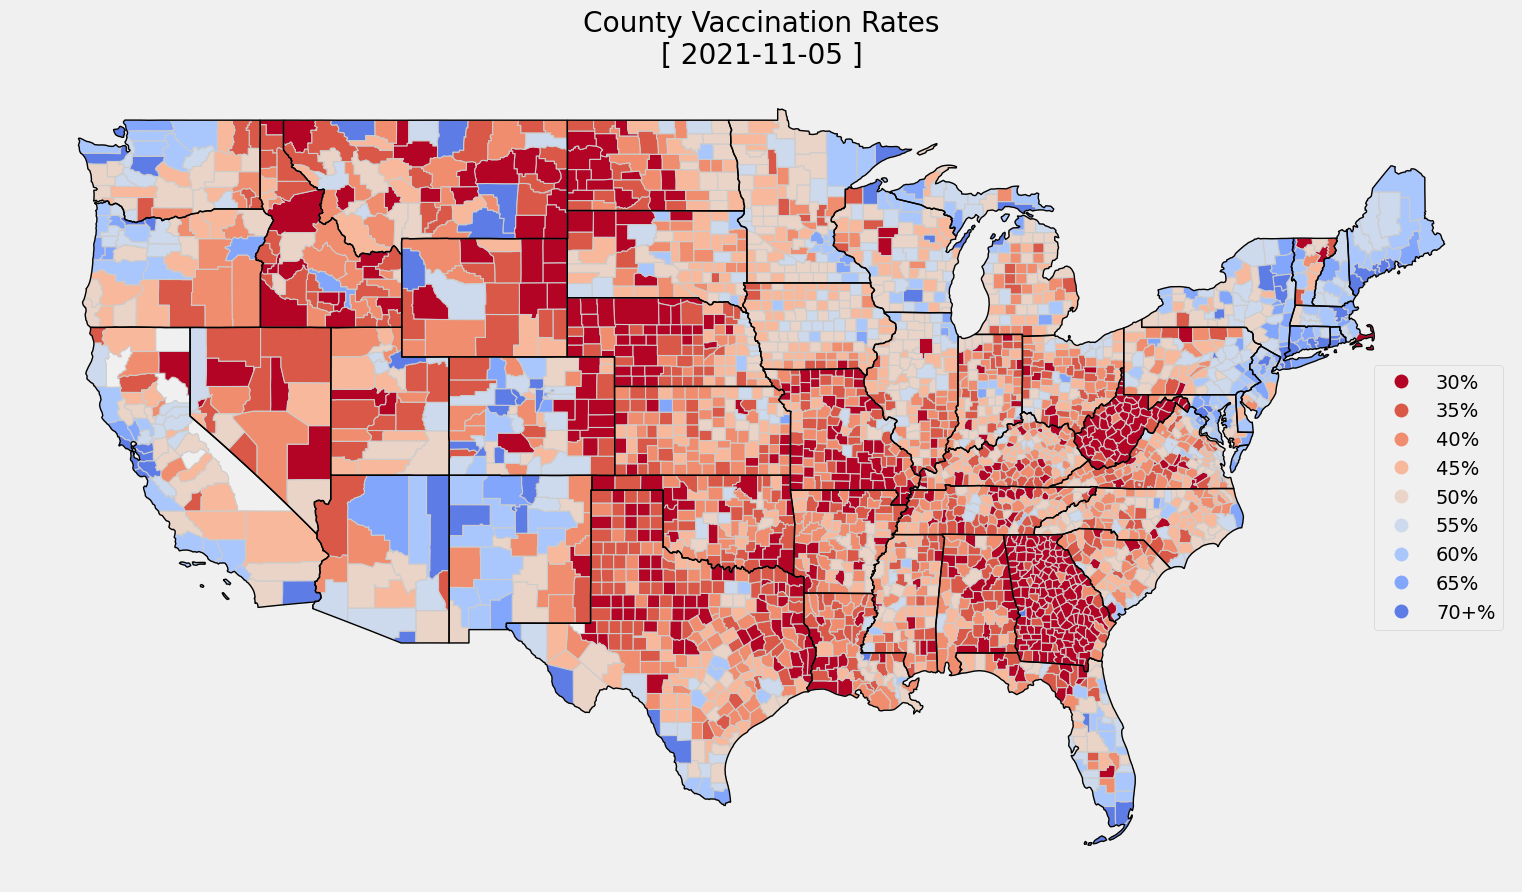

'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [70]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [30]:
geo_county_tier_df

STATEFP  GEOID      NAME                                           geometry   FIPS      tier
0          37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  37017  total_40
1          37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  37167  total_35
2          39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  39153  total_55
3          42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  42113  total_45
4          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  48459  total_30
...       ...    ...       ...                                                ...    ...       ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...  22003  total_30
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  38005  total_45
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  31159  total_45
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  37023  total_40
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  13261  total_35

[3099 rows x 6 columns]

In [31]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 127


{'start_daily_100k_confirm': 0    10237
 1    10903
 2    10558
 3    10728
 4    10567
 5     9636
 6    10170
 7     9672
 8     9275
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9275,
 'start_daily_100k_confirm_max': 10903,
 'start_daily_mean_confirm': 0     3653.228963
 1     3593.778865
 2     4773.710372
 3     7277.322896
 4    12302.485323
 5    10214.493151
 6    13337.193738
 7     4563.091977
 8     5151.726027
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7142.834646
 10     7371.259843
 11     9681.133858
 12    12511.661417
 13    20121.314961
 14    15408.401575
 15    15531.661417
 16     4316.637795
 17     5409.598425
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     70.193738
 1     69.178082
 2     90.060665
 3    128.275930
 4    198.739726
 5    159.645793
 6    258.295499
 7     87.500978
 8    100.589041
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     110.6

In [32]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10237
 1    10903
 2    10558
 3    10728
 4    10567
 5     9636
 6    10170
 7     9672
 8     9275
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9275,
 'start_daily_100k_confirm_max': 10903,
 'start_daily_mean_confirm': 0     3653.228963
 1     3593.778865
 2     4773.710372
 3     7277.322896
 4    12302.485323
 5    10214.493151
 6    13337.193738
 7     4563.091977
 8     5151.726027
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7142.834646
 10     7371.259843
 11     9681.133858
 12    12511.661417
 13    20121.314961
 14    15408.401575
 15    15531.661417
 16     4316.637795
 17     5409.598425
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     70.193738
 1     69.178082
 2     90.060665
 3    128.275930
 4    198.739726
 5    159.645793
 6    258.295499
 7     87.500978
 8    100.589041
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     110.6

In [33]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc             FIPS      tier total_beds beds_used  \
5902    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5903    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5904    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5905    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
5906    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID     [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..              ...       ...        ...       ...   
3919    6592849 2021-11-01     13159      727977      1807          7     2406.571429     36.502754        28.142857       0.426869  CT  [9, 23, 44, 50]  total_70    14519.0   11058.0   
3920    6592849 2021-11-02     13181      729648      3210         29     2449.142857     37.148475        26.142857       0.396534  CT  [9, 23, 44, 50]  total_70    14560.0   11515.0   
3921    6592849 2021-11-03     13205      731214      3237         46     2513.000000     38.117057        23.571429        0.35753  CT  [9, 23, 44, 50]  total_70    15367.0   12297.0   
3922    6592849 2021-11-04     13215      733185      3537         34     2592.000000     39.315325        24.428571       0.370531  CT  [9, 23, 44, 50]  total_70    15401.0   12258.0   
3923    6592849 2021-11-05     13239      734766      3552         34     2653.428571      40.24707        25.428571       0.385699  CT  [9, 23, 44, 50]  total_70    15452.0   12344.0   

     covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5902             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5903             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5904             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5905             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
5906             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                ...       ...              ...             ...              ...               ...  
3919           584.0    1608.0  0.462051830435809     151.0            575.0             9.0        36.502754          0.426869  
3920           603.0    1606.0  0.523824459300919     158.0            591.0            12.0        37.148475          0.396534  
3921           617.0    1593.0  0.543008320490659     155.0            608.0             9.0        38.117057           0.35753  
3922           613.0    1596.0  0.595937384510524     163.0            605.0             8.0        39.315325          0.370531  
3923           600.0    1606.0  0.524727066568726     154.0            586.0            14.0         40.24707          0.385699  

[4466 rows x 23 columns]

In [34]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
21267 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21229 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21167 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
21143 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
21080 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
270   2021-11-02       US                 221961370                        66.9                        221727848                                    78.2                        206751110   
253   2021-11-03       US                 222268786                        66.9                        222035147                                    78.3                        207040830   
154   2021-11-04       US                 222591394                        67.0                        222357053                                    78.4                        207344425   
84    2021-11-05       US                 222902939                        67.1                        222656537                                    78.5                        207630146   
62    2021-11-06       US                 223245121                        67.2                        222965329                                    78.6                        207920448   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
21267                                     0.0                                0                                     0.0                    0                      0.0                       0   
21229                                     0.0                                0                                     0.0                    0                      0.0                       0   
21167                                     0.0                                0                                     0.0                    0                      0.0                       0   
21143                                     0.0                                0                                     0.0                    0                      0.0                       0   
21080                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
270                                      80.1                         53327428                                    97.5            192726406                     58.1               192590702   
253                                      80.2                         53419001                                    97.7            192931486                     58.1               192795739   
154            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [35]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_40': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8523781350078431,
  0.34649194649411763,
  0.2803464686980392,
  1.0),
 'total_55': (0.9440545734235294, 0.5531534787490197, 0.4355484903137255, 1.0),
 'total_45': (0.968203399, 0.7208441, 0.6122929913333334, 1.0),
 'total_30': (0.9193759889058823, 0.8312727235294118, 0.7828736304470588, 1.0),
 'total_50': (0.8049647588235295, 0.8516661605568627, 0.9261650744313725, 1.0),
 'total_70': (0.6672529243333334, 0.7791764569999999, 0.992959213, 1.0),
 'total_60': (0.5108243242509803, 0.6493966148235294, 0.9850787763764707, 1.0),
 'total_65': (0.3634607953411765, 0.4847836818509804, 0.9010188868941177, 1.0)}

In [36]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [37]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_637.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_637.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_637.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_638.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_638.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_638.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_639.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_639.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_639.jpg
Done...
Done!


In [38]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jp

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_42.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_43.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_43.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_43.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_44.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_44.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_44.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_45.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_45.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_83.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_83.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_83.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_84.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_84.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_84.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_85.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_85.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_85.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_123.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_123.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_123.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_124.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_124.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_124.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_125.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_125.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_125.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_165.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_166.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_166.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_166.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_167.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_167.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_167.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_168.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_168.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_201.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_201.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_202.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_202.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_202.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_203.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_203.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_203.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_204.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_230.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_231.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_231.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_231.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_232.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_232.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_232.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_233.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_233.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_266.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_266.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_266.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_267.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_267.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_267.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_268.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_268.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_268.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_309.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_309.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_309.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_310.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_310.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_310.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_311.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_311.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_311.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_342.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_342.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_342.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_343.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_343.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_343.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_344.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_344.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_344.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_373.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_373.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_374.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_374.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_374.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_375.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_375.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_375.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_376.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_404.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_405.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_405.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_405.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_406.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_406.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_406.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_407.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_407.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_435.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_436.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_436.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_436.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_437.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_437.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_437.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_438.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_438.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_463.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_463.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_464.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_464.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_464.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_465.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_465.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_465.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_466.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_492.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_492.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_492.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_493.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_493.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_493.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_494.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_494.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_494.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_521.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_521.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_521.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_522.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_522.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_522.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_523.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_523.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_523.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_552.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_553.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_553.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_553.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_554.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_554.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_554.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_555.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_555.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_584.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_584.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_584.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_585.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_585.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_585.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_586.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_586.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_586.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_612.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_612.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_612.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_613.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_613.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_613.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_614.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_614.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_614.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

In [39]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


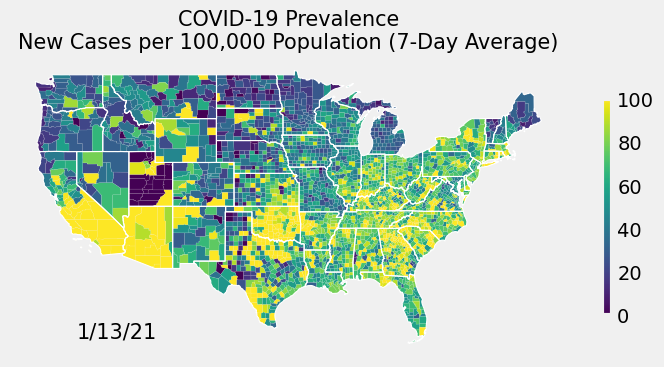

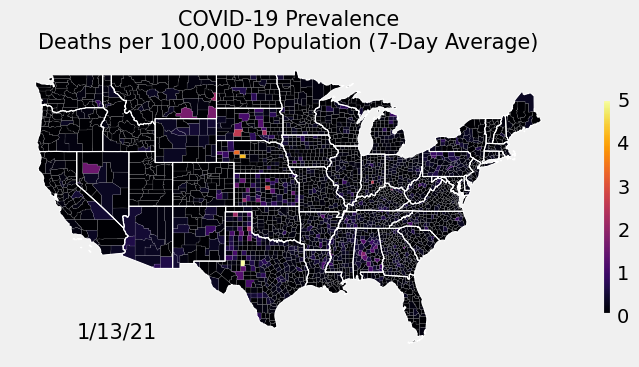

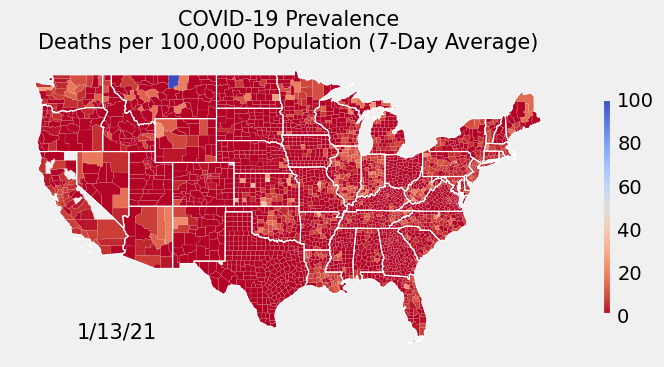

Done...
Done!


In [40]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [41]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [42]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [43]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [44]:
county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1017095      17221       16199        110    22679.428571   
335  2020-12-22  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1030733      17429       20575        256    22784.142857   
336  2020-12-23  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1043315      17624       26220        403    22928.142857   
337  2020-12-24  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1057617      17798       26884        369    23078.714286   
338  2020-12-25  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288     1065409      17896       22094        272    22298.857143   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
649  2021-11-01  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3303824      54233        8907         53     7874.285714   
650  2021-11-02  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3306825      54268        9033         83     7655.857143   
651  2021-11-03  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       277.000000    124.371102       1.519033              100          1.519033                      0.0                      0            0.0              0.0  total_30  
335       277.428571    124.945341       1.521383              100          1.521383                      0.0                      0            0.0              0.0  total_30  
336       282.142857    125.735019       1.547236              100          1.547236                      0.0                      0            0.0              0.0  total_30  
337       280.857143    126.560734       1.540185              100          1.540185                      0.0                      0            0.0              0.0  total_30  
338       274.714286    122.284096       1.506498              100          1.506498                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
649        68.714286     27.743805       0.242104        27.743805          0.242104                73.252063               20790503       81.91982       23250598.0  total_70  
650        64.571429     26.974207       0.227507        26.974207          0.227507                73.301967               20804667      81.994832       23271888.0  total_70  
651        62.285714     26.950047       0.219454        26.950047          0.219454                73.357855               20820529       82.07954       23295930.0  total_7

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [45]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 5)

In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0015 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/07 total_30 0 total_30 0.0 0% 0%
10 2020/02/07 total_35 0 total_35 0.0 0% 0%
11 2020/02/07 total_40 0 total_40 0.0 0% 0%
12 2020/02/07 total_45 0 total_45 0.0 0% 0%
13 2020/02/07 total_50 0 total_50 0.0 0% 0%
14 2020/02/07 total_55 0 total_55 0.0 0% 0%
15 2020/02/07 total_60 1 total_60 0.0015 0% 0%
16 2020/02/07 total_65 0 total_65 0.0 0% 0%
17 2020/02/07 total_70 0 total_70 0.0 0% 0%
18 2020/02/08 total_30 0 total_30 0.0 0% 0%
19 2020/02/08 total_35 0 total_35 0.0 0% 0%
20 2020/02/08 total_40 0 total_40 0.0 0% 0%
21 2020/02/08 total_45 0 total_45 0.0 0% 0%
22 2020/02/08 total_50 0 total_50 0.

266 2020/03/06 total_55 14 total_55 0.0258 469.09% 0%
267 2020/03/06 total_60 23 total_60 0.0343 623.64% 0%
268 2020/03/06 total_65 20 total_65 0.083 1509.09% 0%
269 2020/03/06 total_70 68 total_70 0.2396 4356.36% 0%
270 2020/03/07 total_30 2 total_30 0.011 100.0% 0%
271 2020/03/07 total_35 1 total_35 0.0059 53.64% 0%
272 2020/03/07 total_40 0 total_40 0.0 0.0% 0%
273 2020/03/07 total_45 4 total_45 0.0115 104.55% 0%
274 2020/03/07 total_50 13 total_50 0.0219 199.09% 0%
275 2020/03/07 total_55 23 total_55 0.0425 386.36% 0%
276 2020/03/07 total_60 25 total_60 0.0373 339.09% 0%
277 2020/03/07 total_65 35 total_65 0.1452 1320.0% 0%
278 2020/03/07 total_70 129 total_70 0.4545 4131.82% 0%
279 2020/03/08 total_30 1 total_30 0.0055 100.0% 0%
280 2020/03/08 total_35 2 total_35 0.0119 216.36% 0%
281 2020/03/08 total_40 0 total_40 0.0 0.0% 0%
282 2020/03/08 total_45 7 total_45 0.0202 367.27% 0%
283 2020/03/08 total_50 15 total_50 0.0252 458.18% 0%
284 2020/03/08 total_55 24 total_55 0.0443 805.45

516 2020/04/03 total_45 4346 total_45 12.5384 152.83% 0%
517 2020/04/03 total_50 5459 total_50 9.1761 111.85% 0%
518 2020/04/03 total_55 8452 total_55 15.6038 190.2% 0%
519 2020/04/03 total_60 18722 total_60 27.9393 340.56% 0%
520 2020/04/03 total_65 9048 total_65 37.5339 457.51% 0%
521 2020/04/03 total_70 13911 total_70 49.0132 597.44% 0%
522 2020/04/04 total_30 1605 total_30 8.8016 100.0% 0%
523 2020/04/04 total_35 1063 total_35 6.3114 71.71% 0%
524 2020/04/04 total_40 1859 total_40 8.0465 91.42% 0%
525 2020/04/04 total_45 4269 total_45 12.3163 139.93% 0%
526 2020/04/04 total_50 5366 total_50 9.0198 102.48% 0%
527 2020/04/04 total_55 8729 total_55 16.1152 183.09% 0%
528 2020/04/04 total_60 19259 total_60 28.7407 326.54% 0%
529 2020/04/04 total_65 10018 total_65 41.5577 472.16% 0%
530 2020/04/04 total_70 13325 total_70 46.9485 533.41% 0%
531 2020/04/05 total_30 1361 total_30 7.4636 100.0% 0%
532 2020/04/05 total_35 988 total_35 5.8661 78.6% 0%
533 2020/04/05 total_40 1746 total_40 7.5

774 2020/05/02 total_30 3354 total_30 18.3929 100.0% 0%
775 2020/05/02 total_35 2174 total_35 12.9078 70.18% 0%
776 2020/05/02 total_40 2456 total_40 10.6306 57.8% 0%
777 2020/05/02 total_45 3615 total_45 10.4295 56.7% 0%
778 2020/05/02 total_50 7185 total_50 12.0773 65.66% 0%
779 2020/05/02 total_55 8846 total_55 16.3312 88.79% 0%
780 2020/05/02 total_60 18360 total_60 27.3991 148.97% 0%
781 2020/05/02 total_65 7906 total_65 32.7965 178.31% 0%
782 2020/05/02 total_70 7286 total_70 25.6711 139.57% 0%
783 2020/05/03 total_30 1888 total_30 10.3536 100.0% 0%
784 2020/05/03 total_35 1752 total_35 10.4023 100.47% 0%
785 2020/05/03 total_40 2053 total_40 8.8862 85.83% 0%
786 2020/05/03 total_45 3472 total_45 10.0169 96.75% 0%
787 2020/05/03 total_50 6017 total_50 10.114 97.69% 0%
788 2020/05/03 total_55 6799 total_55 12.5521 121.23% 0%
789 2020/05/03 total_60 16446 total_60 24.5428 237.05% 0%
790 2020/05/03 total_65 6832 total_65 28.3412 273.73% 0%
791 2020/05/03 total_70 5788 total_70 20.39

1078 2020/06/04 total_65 3158 total_65 13.1004 93.24% 0%
1079 2020/06/04 total_70 3200 total_70 11.2747 80.25% 0%
1080 2020/06/05 total_30 2581 total_30 14.1539 100.0% 0%
1081 2020/06/05 total_35 2463 total_35 14.6237 103.32% 0%
1082 2020/06/05 total_40 2688 total_40 11.6348 82.2% 0%
1083 2020/06/05 total_45 4573 total_45 13.1934 93.21% 0%
1084 2020/06/05 total_50 7709 total_50 12.9581 91.55% 0%
1085 2020/06/05 total_55 7752 total_55 14.3115 101.11% 0%
1086 2020/06/05 total_60 11252 total_60 16.7917 118.64% 0%
1087 2020/06/05 total_65 3354 total_65 13.9134 98.3% 0%
1088 2020/06/05 total_70 3569 total_70 12.5748 88.84% 0%
1089 2020/06/06 total_30 2100 total_30 11.5161 100.0% 0%
1090 2020/06/06 total_35 2549 total_35 15.1343 131.42% 0%
1091 2020/06/06 total_40 2626 total_40 11.3664 98.7% 0%
1092 2020/06/06 total_45 4731 total_45 13.6492 118.52% 0%
1093 2020/06/06 total_50 8129 total_50 13.6641 118.65% 0%
1094 2020/06/06 total_55 7646 total_55 14.1158 122.57% 0%
1095 2020/06/06 total_60 1

1328 2020/07/02 total_55 15807 total_55 29.1823 82.82% 0%
1329 2020/07/02 total_60 21012 total_60 31.3568 89.0% 0%
1330 2020/07/02 total_65 3275 total_65 13.5857 38.56% 0%
1331 2020/07/02 total_70 7363 total_70 25.9424 73.63% 0%
1332 2020/07/03 total_30 7038 total_30 38.5955 100.0% 0%
1333 2020/07/03 total_35 5874 total_35 34.8761 90.36% 0%
1334 2020/07/03 total_40 7323 total_40 31.697 82.13% 0%
1335 2020/07/03 total_45 12387 total_45 35.7372 92.59% 0%
1336 2020/07/03 total_50 27551 total_50 46.3107 119.99% 0%
1337 2020/07/03 total_55 16857 total_55 31.1208 80.63% 0%
1338 2020/07/03 total_60 18839 total_60 28.1139 72.84% 0%
1339 2020/07/03 total_65 3662 total_65 15.1911 39.36% 0%
1340 2020/07/03 total_70 8240 total_70 29.0323 75.22% 0%
1341 2020/07/04 total_30 7352 total_30 40.3174 100.0% 0%
1342 2020/07/04 total_35 4717 total_35 28.0065 69.47% 0%
1343 2020/07/04 total_40 6291 total_40 27.23 67.54% 0%
1344 2020/07/04 total_45 12057 total_45 34.7851 86.28% 0%
1345 2020/07/04 total_50 25

1578 2020/07/30 total_45 16802 total_45 48.4747 88.6% 0%
1579 2020/07/30 total_50 27258 total_50 45.8182 83.74% 0%
1580 2020/07/30 total_55 18615 total_55 34.3663 62.81% 0%
1581 2020/07/30 total_60 28328 total_60 42.2746 77.27% 0%
1582 2020/07/30 total_65 5194 total_65 21.5463 39.38% 0%
1583 2020/07/30 total_70 10376 total_70 36.5582 66.82% 0%
1584 2020/07/31 total_30 10278 total_30 56.3632 100.0% 0%
1585 2020/07/31 total_35 8836 total_35 52.4626 93.08% 0%
1586 2020/07/31 total_40 10259 total_40 44.4052 78.78% 0%
1587 2020/07/31 total_45 16360 total_45 47.1995 83.74% 0%
1588 2020/07/31 total_50 29198 total_50 49.0792 87.08% 0%
1589 2020/07/31 total_55 19990 total_55 36.9048 65.48% 0%
1590 2020/07/31 total_60 24243 total_60 36.1785 64.19% 0%
1591 2020/07/31 total_65 5449 total_65 22.6041 40.1% 0%
1592 2020/07/31 total_70 9648 total_70 33.9932 60.31% 0%
1593 2020/08/01 total_30 9397 total_30 51.532 100.0% 0%
1594 2020/08/01 total_35 7906 total_35 46.9408 91.09% 0%
1595 2020/08/01 total_4

1852 2020/08/29 total_65 4228 total_65 17.539 41.01% 0%
1853 2020/08/29 total_70 5047 total_70 17.7823 41.58% 0%
1854 2020/08/30 total_30 5945 total_30 32.6016 100.0% 0%
1855 2020/08/30 total_35 5208 total_35 30.9218 94.85% 0%
1856 2020/08/30 total_40 6934 total_40 30.0132 92.06% 0%
1857 2020/08/30 total_45 9613 total_45 27.734 85.07% 0%
1858 2020/08/30 total_50 15712 total_50 26.4105 81.01% 0%
1859 2020/08/30 total_55 13341 total_55 24.6297 75.55% 0%
1860 2020/08/30 total_60 11768 total_60 17.5617 53.87% 0%
1861 2020/08/30 total_65 3767 total_65 15.6267 47.93% 0%
1862 2020/08/30 total_70 4407 total_70 15.5274 47.63% 0%
1863 2020/08/31 total_30 4868 total_30 26.6955 100.0% 0%
1864 2020/08/31 total_35 4871 total_35 28.9209 108.34% 0%
1865 2020/08/31 total_40 6101 total_40 26.4076 98.92% 0%
1866 2020/08/31 total_45 7988 total_45 23.0458 86.33% 0%
1867 2020/08/31 total_50 13495 total_50 22.6839 84.97% 0%
1868 2020/08/31 total_55 10722 total_55 19.7946 74.15% 0%
1869 2020/08/31 total_60 10

2140 2020/09/30 total_65 4206 total_65 17.4478 60.02% 0%
2141 2020/09/30 total_70 4752 total_70 16.7429 57.6% 0%
2142 2020/10/01 total_30 5719 total_30 31.3623 100.0% 0%
2143 2020/10/01 total_35 5987 total_35 35.547 113.34% 0%
2144 2020/10/01 total_40 8367 total_40 36.2158 115.48% 0%
2145 2020/10/01 total_45 11227 total_45 32.3905 103.28% 0%
2146 2020/10/01 total_50 15006 total_50 25.2237 80.43% 0%
2147 2020/10/01 total_55 15028 total_55 27.7441 88.46% 0%
2148 2020/10/01 total_60 12858 total_60 19.1883 61.18% 0%
2149 2020/10/01 total_65 4352 total_65 18.0534 57.56% 0%
2150 2020/10/01 total_70 5007 total_70 17.6414 56.25% 0%
2151 2020/10/02 total_30 7114 total_30 39.0123 100.0% 0%
2152 2020/10/02 total_35 7541 total_35 44.7737 114.77% 0%
2153 2020/10/02 total_40 10184 total_40 44.0805 112.99% 0%
2154 2020/10/02 total_45 12713 total_45 36.6777 94.02% 0%
2155 2020/10/02 total_50 17696 total_50 29.7454 76.25% 0%
2156 2020/10/02 total_55 18685 total_55 34.4955 88.42% 0%
2157 2020/10/02 tota

2408 2020/10/30 total_55 31863 total_55 58.8243 116.72% 0%
2409 2020/10/30 total_60 29142 total_60 43.4894 86.29% 0%
2410 2020/10/30 total_65 14845 total_65 61.5816 122.19% 0%
2411 2020/10/30 total_70 9424 total_70 33.204 65.89% 0%
2412 2020/10/31 total_30 10499 total_30 57.5752 100.0% 0%
2413 2020/10/31 total_35 12908 total_35 76.6395 133.11% 0%
2414 2020/10/31 total_40 16832 total_40 72.8558 126.54% 0%
2415 2020/10/31 total_45 22410 total_45 64.6541 112.3% 0%
2416 2020/10/31 total_50 37018 total_50 62.2239 108.07% 0%
2417 2020/10/31 total_55 32478 total_55 59.9597 104.14% 0%
2418 2020/10/31 total_60 28452 total_60 42.4597 73.75% 0%
2419 2020/10/31 total_65 14214 total_65 58.964 102.41% 0%
2420 2020/10/31 total_70 9021 total_70 31.7841 55.2% 0%
2421 2020/11/01 total_30 15381 total_30 84.3474 100.0% 0%
2422 2020/11/01 total_35 15412 total_35 91.5067 108.49% 0%
2423 2020/11/01 total_40 24975 total_40 108.1021 128.16% 0%
2424 2020/11/01 total_45 21947 total_45 63.3183 75.07% 0%
2425 2020

2703 2020/12/02 total_45 48809 total_45 140.8166 123.47% 0%
2704 2020/12/02 total_50 77536 total_50 130.331 114.27% 0%
2705 2020/12/02 total_55 61904 total_55 114.2848 100.2% 0%
2706 2020/12/02 total_60 74069 total_60 110.5351 96.92% 0%
2707 2020/12/02 total_65 26710 total_65 110.8013 97.15% 0%
2708 2020/12/02 total_70 24313 total_70 85.663 75.11% 0%
2709 2020/12/03 total_30 22520 total_30 123.4968 100.0% 0%
2710 2020/12/03 total_35 26275 total_35 156.0043 126.32% 0%
2711 2020/12/03 total_40 35245 total_40 152.5549 123.53% 0%
2712 2020/12/03 total_45 49983 total_45 144.2037 116.77% 0%
2713 2020/12/03 total_50 80412 total_50 135.1653 109.45% 0%
2714 2020/12/03 total_55 66031 total_55 121.9039 98.71% 0%
2715 2020/12/03 total_60 81275 total_60 121.2888 98.21% 0%
2716 2020/12/03 total_65 32025 total_65 132.8495 107.57% 0%
2717 2020/12/03 total_70 27738 total_70 97.7305 79.14% 0%
2718 2020/12/04 total_30 23508 total_30 128.9149 100.0% 0%
2719 2020/12/04 total_35 27180 total_35 161.3776 125.

3012 2021/01/05 total_60 90083 total_60 134.4332 108.36% 0.0%
3013 2021/01/05 total_65 27079 total_65 112.332 90.55% 0.0%
3014 2021/01/05 total_70 29403 total_70 103.5968 83.51% 0.0%
3015 2021/01/06 total_30 29148 total_30 159.8439 100.0% 0.0%
3016 2021/01/06 total_35 27508 total_35 163.325 102.18% 0.0%
3017 2021/01/06 total_40 39460 total_40 170.7991 106.85% 0.0%
3018 2021/01/06 total_45 55933 total_45 161.3698 100.95% 0.0%
3019 2021/01/06 total_50 92906 total_50 156.1666 97.7% 0.0%
3020 2021/01/06 total_55 64893 total_55 119.803 74.95% 0.0%
3021 2021/01/06 total_60 104758 total_60 156.3331 97.8% 0.0%
3022 2021/01/06 total_65 30375 total_65 126.0048 78.83% 0.0%
3023 2021/01/06 total_70 36078 total_70 127.1152 79.52% 0.0%
3024 2021/01/07 total_30 29497 total_30 161.7578 100.0% 0.0%
3025 2021/01/07 total_35 29155 total_35 173.1039 107.01% 0.0%
3026 2021/01/07 total_40 41381 total_40 179.114 110.73% 0.0%
3027 2021/01/07 total_45 61614 total_45 177.7598 109.89% 0.0%
3028 2021/01/07 total_

3265 2021/02/02 total_65 14776 total_65 61.2954 79.81% 2.2%
3266 2021/02/02 total_70 19390 total_70 68.3176 88.95% 0.0%
3267 2021/02/03 total_30 15441 total_30 84.6765 100.0% 0.0%
3268 2021/02/03 total_35 13221 total_35 78.4979 92.7% 0.8%
3269 2021/02/03 total_40 19860 total_40 85.9623 101.52% 1.5%
3270 2021/02/03 total_45 27868 total_45 80.4007 94.95% 2.7%
3271 2021/02/03 total_50 45486 total_50 76.4579 90.29% 3.1%
3272 2021/02/03 total_55 34568 total_55 63.8181 75.37% 1.2%
3273 2021/02/03 total_60 49305 total_60 73.5791 86.89% 1.3%
3274 2021/02/03 total_65 13608 total_65 56.4502 66.67% 2.6%
3275 2021/02/03 total_70 18690 total_70 65.8513 77.77% 0.0%
3276 2021/02/04 total_30 16712 total_30 91.6465 100.0% 0.0%
3277 2021/02/04 total_35 14061 total_35 83.4853 91.09% 0.8%
3278 2021/02/04 total_40 21322 total_40 92.2904 100.7% 2.2%
3279 2021/02/04 total_45 29541 total_45 85.2274 93.0% 2.8%
3280 2021/02/04 total_50 48557 total_50 81.6199 89.06% 3.2%
3281 2021/02/04 total_55 36492 total_55 6

3578 2021/03/09 total_55 16272 total_55 30.0408 121.71% 7.1%
3579 2021/03/09 total_60 22187 total_60 33.1102 134.14% 7.4%
3580 2021/03/09 total_65 9576 total_65 39.7242 160.94% 16.4%
3581 2021/03/09 total_70 11208 total_70 39.4896 159.99% 4.4%
3582 2021/03/10 total_30 5493 total_30 30.1229 100.0% 0.0%
3583 2021/03/10 total_35 5146 total_35 30.5537 101.43% 7.8%
3584 2021/03/10 total_40 6787 total_40 29.3769 97.52% 11.4%
3585 2021/03/10 total_45 10872 total_45 31.3663 104.13% 12.5%
3586 2021/03/10 total_50 18480 total_50 31.0632 103.12% 11.9%
3587 2021/03/10 total_55 18321 total_55 33.8235 112.29% 7.3%
3588 2021/03/10 total_60 26568 total_60 39.6481 131.62% 7.6%
3589 2021/03/10 total_65 9819 total_65 40.7322 135.22% 17.3%
3590 2021/03/10 total_70 12148 total_70 42.8016 142.09% 4.4%
3591 2021/03/11 total_30 20186 total_30 110.6975 100.0% 0.0%
3592 2021/03/11 total_35 18053 total_35 107.1872 96.83% 7.8%
3593 2021/03/11 total_40 21804 total_40 94.3767 85.26% 11.6%
3594 2021/03/11 total_45 2

3890 2021/04/13 total_40 8065 total_40 34.9086 139.97% 17.0%
3891 2021/04/13 total_45 17552 total_45 50.6385 203.04% 21.5%
3892 2021/04/13 total_50 24588 total_50 41.3302 165.71% 29.0%
3893 2021/04/13 total_55 23908 total_55 44.1381 176.97% 18.5%
3894 2021/04/13 total_60 30612 total_60 45.6831 183.17% 18.6%
3895 2021/04/13 total_65 13073 total_65 54.2308 217.44% 32.0%
3896 2021/04/13 total_70 12530 total_70 44.1475 177.01% 21.6%
3897 2021/04/14 total_30 5763 total_30 31.6036 100.0% 0.0%
3898 2021/04/14 total_35 5364 total_35 31.848 100.77% 11.5%
3899 2021/04/14 total_40 8974 total_40 38.8432 122.91% 17.3%
3900 2021/04/14 total_45 17689 total_45 51.0337 161.48% 22.1%
3901 2021/04/14 total_50 26710 total_50 44.8971 142.06% 29.2%
3902 2021/04/14 total_55 27497 total_55 50.7639 160.63% 18.5%
3903 2021/04/14 total_60 33189 total_60 49.5288 156.72% 19.0%
3904 2021/04/14 total_65 13943 total_65 57.8398 183.02% 32.8%
3905 2021/04/14 total_70 12964 total_70 45.6766 144.53% 23.3%
3906 2021/04/15

4201 2021/05/17 total_65 3085 total_65 12.7975 123.41% 46.5%
4202 2021/05/17 total_70 3430 total_70 12.0851 116.54% 48.6%
4203 2021/05/18 total_30 2414 total_30 13.2381 100.0% 0.0%
4204 2021/05/18 total_35 2776 total_35 16.4821 124.51% 14.8%
4205 2021/05/18 total_40 4599 total_40 19.9064 150.37% 21.8%
4206 2021/05/18 total_45 7337 total_45 21.1676 159.9% 31.0%
4207 2021/05/18 total_50 11148 total_50 18.7388 141.55% 40.0%
4208 2021/05/18 total_55 9533 total_55 17.5995 132.95% 33.2%
4209 2021/05/18 total_60 9782 total_60 14.5979 110.27% 31.1%
4210 2021/05/18 total_65 3101 total_65 12.8639 97.17% 46.6%
4211 2021/05/18 total_70 3648 total_70 12.8532 97.09% 52.0%
4212 2021/05/19 total_30 2905 total_30 15.9307 100.0% 0.0%
4213 2021/05/19 total_35 2867 total_35 17.0224 106.85% 15.0%
4214 2021/05/19 total_40 5075 total_40 21.9667 137.89% 21.8%
4215 2021/05/19 total_45 7150 total_45 20.6281 129.49% 31.3%
4216 2021/05/19 total_50 11426 total_50 19.2061 120.56% 40.3%
4217 2021/05/19 total_55 1002

4475 2021/06/17 total_40 2592 total_40 11.2192 96.96% 23.8%
4476 2021/06/17 total_45 2830 total_45 8.1647 70.56% 37.1%
4477 2021/06/17 total_50 4891 total_50 8.2213 71.05% 43.8%
4478 2021/06/17 total_55 3086 total_55 5.6973 49.24% 38.2%
4479 2021/06/17 total_60 3780 total_60 5.641 48.75% 39.1%
4480 2021/06/17 total_65 1152 total_65 4.7788 41.3% 53.7%
4481 2021/06/17 total_70 1100 total_70 3.8757 33.49% 60.0%
4482 2021/06/18 total_30 1765 total_30 9.679 100.0% 0.0%
4483 2021/06/18 total_35 1869 total_35 11.0969 114.65% 16.8%
4484 2021/06/18 total_40 2629 total_40 11.3794 117.57% 23.8%
4485 2021/06/18 total_45 2845 total_45 8.208 84.8% 37.2%
4486 2021/06/18 total_50 7414 total_50 12.4623 128.76% 43.9%
4487 2021/06/18 total_55 4156 total_55 7.6727 79.27% 38.4%
4488 2021/06/18 total_60 5738 total_60 8.563 88.47% 39.3%
4489 2021/06/18 total_65 1191 total_65 4.9406 51.04% 53.9%
4490 2021/06/18 total_70 3133 total_70 11.0386 114.05% 60.2%
4491 2021/06/19 total_30 1959 total_30 10.7429 100.0% 

4765 2021/07/19 total_50 17788 total_50 29.9 123.3% 45.2%
4766 2021/07/19 total_55 9765 total_55 18.0278 74.34% 40.9%
4767 2021/07/19 total_60 9045 total_60 13.4981 55.66% 44.5%
4768 2021/07/19 total_65 2345 total_65 9.7278 40.12% 57.1%
4769 2021/07/19 total_70 5374 total_70 18.9344 78.08% 62.9%
4770 2021/07/20 total_30 6858 total_30 37.6084 100.0% 0.0%
4771 2021/07/20 total_35 6397 total_35 37.9813 100.99% 18.0%
4772 2021/07/20 total_40 10217 total_40 44.2234 117.59% 25.1%
4773 2021/07/20 total_45 11166 total_45 32.2145 85.66% 39.1%
4774 2021/07/20 total_50 20283 total_50 34.0939 90.66% 45.3%
4775 2021/07/20 total_55 11986 total_55 22.1281 58.84% 41.0%
4776 2021/07/20 total_60 13134 total_60 19.6002 52.12% 44.6%
4777 2021/07/20 total_65 3295 total_65 13.6687 36.34% 57.2%
4778 2021/07/20 total_70 4072 total_70 14.3471 38.15% 62.9%
4779 2021/07/21 total_30 7233 total_30 39.6649 100.0% 0.0%
4780 2021/07/21 total_35 7889 total_35 46.8399 118.09% 18.1%
4781 2021/07/21 total_40 10859 total_

5077 2021/08/23 total_35 21244 total_35 126.1334 89.23% 19.5%
5078 2021/08/23 total_40 27467 total_40 118.8885 84.11% 27.1%
5079 2021/08/23 total_45 37188 total_45 107.2894 75.9% 41.0%
5080 2021/08/23 total_50 47711 total_50 80.1979 56.74% 46.9%
5081 2021/08/23 total_55 33971 total_55 62.716 44.37% 42.9%
5082 2021/08/23 total_60 33815 total_60 50.463 35.7% 48.5%
5083 2021/08/23 total_65 10414 total_65 43.2005 30.56% 59.6%
5084 2021/08/23 total_70 11094 total_70 39.088 27.65% 64.5%
5085 2021/08/24 total_30 36803 total_30 201.823 100.0% 0.0%
5086 2021/08/24 total_35 30297 total_35 179.8843 89.13% 19.7%
5087 2021/08/24 total_40 38781 total_40 167.8601 83.17% 27.3%
5088 2021/08/24 total_45 51599 total_45 148.8659 73.76% 41.1%
5089 2021/08/24 total_50 64003 total_50 107.5833 53.31% 47.0%
5090 2021/08/24 total_55 47617 total_55 87.9087 43.56% 43.0%
5091 2021/08/24 total_60 44364 total_60 66.2056 32.8% 48.7%
5092 2021/08/24 total_65 13974 total_65 57.9684 28.72% 59.7%
5093 2021/08/24 total_70

5372 2021/09/24 total_70 18277 total_70 64.3961 59.14% 66.6%
5373 2021/09/25 total_30 17583 total_30 96.4229 100.0% 0.0%
5374 2021/09/25 total_35 20442 total_35 121.3716 125.87% 22.0%
5375 2021/09/25 total_40 22716 total_40 98.3242 101.97% 30.8%
5376 2021/09/25 total_45 26777 total_45 77.2531 80.12% 43.1%
5377 2021/09/25 total_50 45805 total_50 76.9941 79.85% 49.4%
5378 2021/09/25 total_55 51793 total_55 95.6183 99.17% 54.7%
5379 2021/09/25 total_60 45412 total_60 67.7695 70.28% 55.3%
5380 2021/09/25 total_65 9358 total_65 38.8199 40.26% 63.3%
5381 2021/09/25 total_70 13053 total_70 45.9902 47.7% 66.7%
5382 2021/09/26 total_30 8745 total_30 47.9565 100.0% 0.0%
5383 2021/09/26 total_35 11282 total_35 66.9853 139.68% 22.1%
5384 2021/09/26 total_40 10619 total_40 45.9634 95.84% 30.9%
5385 2021/09/26 total_45 11796 total_45 34.0321 70.96% 43.2%
5386 2021/09/26 total_50 21146 total_50 35.5445 74.12% 49.4%
5387 2021/09/26 total_55 28953 total_55 53.4519 111.46% 54.8%
5388 2021/09/26 total_60

5656 2021/10/26 total_50 37701 total_50 63.372 133.8% 50.8%
5657 2021/10/26 total_55 31351 total_55 57.879 122.2% 56.2%
5658 2021/10/26 total_60 27668 total_60 41.2897 87.17% 60.4%
5659 2021/10/26 total_65 11720 total_65 48.6182 102.65% 65.1%
5660 2021/10/26 total_70 10562 total_70 37.2135 78.57% 75.7%
5661 2021/10/27 total_30 12472 total_30 68.3949 100.0% 30.4%
5662 2021/10/27 total_35 14874 total_35 88.3124 129.12% 36.8%
5663 2021/10/27 total_40 16341 total_40 70.7306 103.42% 44.2%
5664 2021/10/27 total_45 23479 total_45 67.7382 99.04% 45.1%
5665 2021/10/27 total_50 34147 total_50 57.398 83.92% 50.9%
5666 2021/10/27 total_55 28692 total_55 52.9701 77.45% 56.3%
5667 2021/10/27 total_60 23642 total_60 35.2816 51.59% 60.5%
5668 2021/10/27 total_65 10029 total_65 41.6034 60.83% 65.2%
5669 2021/10/27 total_70 6762 total_70 23.8248 34.83% 75.8%
5670 2021/10/28 total_30 12835 total_30 70.3855 100.0% 30.5%
5671 2021/10/28 total_35 14867 total_35 88.2708 125.41% 36.9%
5672 2021/10/28 total_40

In [47]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70']
['#b40426', '#d95847', '#f18d6f', '#f7b89c', '#ead4c8', '#cdd9ec', '#aac7fd', '#82a6fb', '#5d7ce6']


In [48]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [49]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [50]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [51]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [52]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [53]:
whole_county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
16   2020-02-07  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
17   2020-02-08  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
18   2020-02-09  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
19   2020-02-10  [21105, 55019, 48115, 8039, 38083, 5067, 31045...    Bibb        Alabama    Bibb, Alabama, US   18235288           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
649  2021-11-01  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3303824      54233        8907         53     7874.285714   
650  2021-11-02  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3306825      54268        9033         83     7655.857143   
651  2021-11-03  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [8059, 36061, 8113, 35055, 8097, 53031, 44005,...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
649        68.714286     27.743805       0.242104        27.743805          0.242104  total_70  
650        64.571429     26.974207       0.227507        26.974207          0.227507  total_70  
651        62.285714     26.950047       0.219454        26.950047          0.219454  total_70  
652        66.285714     27.061787       0.233547        27.061787          0.233547  total_70  
653        69.285714     26.984777       0.244117        26.984777          0.244117  total_70  

[5751 rows x 17 columns]

In [54]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [55]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [56]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-05 00:00:00'),
  'confirm_period': 388192,
  'confirm_start': 289343,
  'confirm_end': 677535,
  'confirm_period_100k': 9336.092050666059,
  'confirm_deaths': 5881,
  'death_period_100k': 141.4391779067242,
  'vax_complete': 1781534,
  'vax_complete_100k': 42846.234377296045,
  'vax_partial': 2060244,
  'vax_partial_100k': 49549.26333060043,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-05 00:00:00'),
  'confirm_period': 3044418,
  'confirm_start': 2653458,
  'confirm_end': 5697876,
  'confirm_period_100k': 9019.270889699123,
  'confirm_deaths': 54964,
  'death_period_100k': 162.8341460277211,
  'vax_complete': 16044727,
  'vax_complete_100k': 47533.46589209154,
  'vax_partial

In [57]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [58]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [59]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [60]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [61]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [62]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                